# Implémentation d'ESN en JAX

In [1]:
import numpy as np
import jax
from jax.experimental import sparse
import matplotlib.pyplot as plt
from functools import partial

from reservoirpy import datasets

## Dataset

In [2]:
# Création de la série temporelle et prétraitement

def dataset(timesteps, forecast, **kwargs):
    mackey_glass = datasets.mackey_glass(timesteps, tau=17)

    # rescale between -1 and 1
    mackey_glass = 2 * (mackey_glass - mackey_glass.min()) / (mackey_glass.max() - mackey_glass.min()) - 1

    return datasets.to_forecasting(
        mackey_glass, 
        forecast=forecast, 
        test_size=0.2
    )

x_train, x_test, y_train, y_test = dataset(
    timesteps=2000,
    forecast=50,
    tau=17,
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1550, 1), (400, 1), (1550, 1), (400, 1))

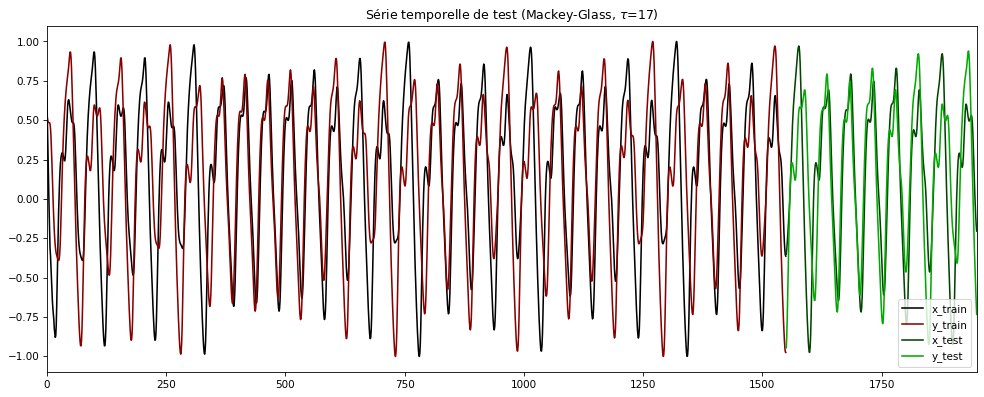

In [3]:
sep = x_train.shape[0]

plt.figure(figsize=(16,6))
plt.plot(np.arange(0, sep), x_train, color="black", label="x_train")
plt.plot(np.arange(0, sep), y_train, color="#880000", label="y_train")
plt.plot(np.arange(sep, sep+x_test.shape[0]), x_test, '-', color="#004400", label="x_test")
plt.plot(np.arange(sep, sep+y_test.shape[0]), y_test, '-', color="#00AA00", label="y_test")
plt.title("Série temporelle de test (Mackey-Glass, $\\tau$=17)")
plt.legend()

plt.show()

## Création du modèle

In [5]:
class ESN:
    
    def __init__(
        self, 
        units, 
        connectivity, 
        input_connectivity, 
        weight_scale, 
        lr, 
        input_scaling,
        input_noise, 
        ridge, 
        seed, 
        input_dim, 
        output_dim,
    ):
        # Création du modèle
        self.key = jax.random.PRNGKey(seed=seed)
        self.key, W_key, Win_key,  = jax.random.split(key=self.key, num=3)
        # Création du réservoir
        self.W = weight_scale * sparse.random_bcoo(
            key = W_key,
            shape = (units, units),
            dtype = np.float32,
            indices_dtype = int,
            nse = connectivity,
            generator = jax.random.normal
        )
        # Création de Win
        self.Win = input_scaling * sparse.random_bcoo(
            key = Win_key,
            shape = (units, input_dim if not input_noise else input_dim+1),
            dtype = np.float32,
            indices_dtype=int,
            nse = input_connectivity,
            generator = ESN._bernoulli
        )

        # état actuel
        self.x = jax.numpy.zeros((units, 1))
        self.Wout = jax.numpy.zeros((output_dim, units+1))

        self.lr = lr
        self.units = units
        self.ridge = ridge
        self.input_noise = input_noise


    # Méthodes fonctionnelles (avec underscore): ne prennent pas d'objet en paramètre (dont self)
    # et ne modifient pas d'état.

    def _bernoulli(key, shape, dtype):
        """ Bernoulli {-1, 1}, p=0.5
        """
        boolean = jax.random.bernoulli(key=key, p=0.5, shape=shape)
        return 2.0 * jax.numpy.array(boolean, dtype=dtype) - 1.0

    
    def _step_reservoir(x, u, W, Win, lr):
        """ 1 pas de temps du réservoir
        """
        u = u.reshape(-1, 1)
        new_x = lr * jax.numpy.tanh(W @ x + Win @ u) + (1 - lr) * x
        return new_x, new_x[:, 0]
    
    def _run_reservoir(W, Win, lr, x, U):
        """ run du réservoir sur une série temporelle
        """
        step_ = partial(ESN._step_reservoir, W=W, Win=Win, lr=lr)
        new_x, states = jax.lax.scan(step_, x, U)
        return new_x, states
    
    def _ridge_regression(ridge, X, Y):
        """ régression ridge entre X et Y
        """
        XXT = X.T @ X
        YXT = Y.T @ X
        n = XXT.shape[0]
        I_n = jax.numpy.eye(n)
        Wout = jax.scipy.linalg.solve(XXT + ridge*I_n, YXT.T, assume_a="sym")

        return Wout.T

    def _fit(W, Win, lr, ridge, x, U, Y):
        """ fait tourner le réservoir, et détermine la matrice Wout
        """
        new_x, X = ESN._run_reservoir(W, Win, lr, x, U)
        Wout = ESN._ridge_regression(ridge, X, Y)

        return new_x, Wout
    
    def _step(x, u, W, Win, Wout, lr):
        """ fait tourner un ESN entraîné sur un pas de temps
        """
        new_x, new_state = ESN._step_reservoir(
            x=x, 
            u=u,
            W=W, 
            Win=Win, 
            lr=lr
        )
        y = Wout @ new_x
        return new_x, y.reshape(-1)
    
    def _run(x, U, W, Win, Wout, lr):
        """ fait tourner un ESN entraîné sur une série temporelle
        """
        step_ = partial(ESN._step, W=W, Win=Win, Wout=Wout, lr=lr)
        new_x, Y = jax.lax.scan(step_, x, U)

        return new_x, Y

    # Méthodes non-fonctionnelles, pour l'API

    def fit(self, U, Y):
        """ Entraîne un ESN
        """
        self.x, self.Wout = ESN._fit(
            W=self.W, 
            Win=self.Win, 
            lr=self.lr, 
            ridge=self.ridge, 
            x=self.x, 
            U=U, 
            Y=Y,
        )

    def run(self, U):
        """ Fait tourner un ESN entraîné sur une série temporelle
        """
        new_x, Y = ESN._run(
            W=self.W, 
            Win=self.Win, 
            lr=self.lr, 
            Wout=self.Wout, 
            x=self.x, 
            U=U,
        )
        return Y

    def plot_Ypred(self, U_train, U_test, Y_train, Y_test):
        """ Entraîne un ESN, le fait tourner sur U_test, affiche la RMSE, et plot prédiction vs réel
        """
        if self.input_noise:
            T_train = U_train.shape[0]
            noise_train = jax.random.bernoulli(key=jax.random.key(0), p=0.5, shape=(T_train, 1))
            U_train = jax.numpy.concatenate((U_train, noise_train), axis=1)

            T_test = U_test.shape[0]
            noise_test = jax.random.bernoulli(key=jax.random.key(1), p=0.5, shape=(T_test, 1))
            U_test = jax.numpy.concatenate((U_test, noise_test), axis=1)

        
        self.fit(U_train, Y_train)
        Y_pred = self.run(U_test)
        rmse = jax.numpy.sqrt(jax.numpy.mean(jax.numpy.square(Y_test - Y_pred)))
        print(rmse)

        plt.figure()
        plt.plot(Y_test, color="black", label="Y_test")
        plt.plot(Y_pred, color="red", label="Y_pred")
        plt.legend()
        plt.show()

        return Y_pred


In [6]:
model = ESN(
    units = 500,
    connectivity = 0.1,
    input_connectivity = 0.1,
    weight_scale = 0.134,
    lr = .9,
    input_scaling = 1.,
    ridge = 1e-3,
    seed = 2341,
    input_dim = 1,
    output_dim = 1,
    input_noise=False,
)

0.05209026


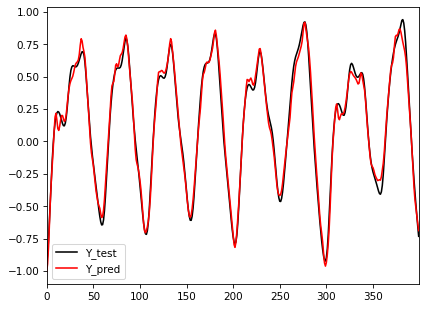

In [7]:
y_pred = model.plot_Ypred(x_train, x_test, y_train, y_test)

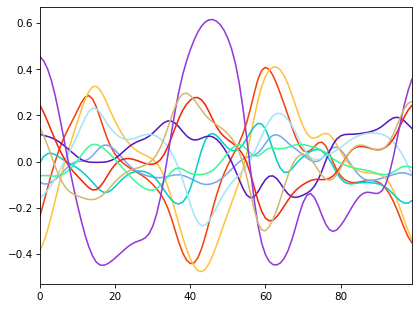

In [8]:
# noise = np.random.uniform(size=x_test.shape)
# x_test_ = np.concatenate((x_test, noise), axis=-1)

# spike = np.zeros((500, 1))
# spike[0, 0] = 1.

states = ESN._run_reservoir(model.W, model.Win, model.lr, model.x, x_test)

plt.figure()
plt.plot(states[1][:100, :10])
plt.show()